# Shallow Convolutional Neural Network - V2

This is just a quick experiment based off Akhil Punia's notebook. I changed the 
size of the convolutional layers to test if the performance on the validation set would improve all else being equal.





## Setting up the Environment


In [0]:
import torch
import torchvision

import numpy as np 
from torchvision import transforms, datasets

## Preparing the Dataset


In [0]:
! wget -q https://storage.googleapis.com/capstone-fs7/img_patches_128_c8.zip
! unzip -q '/content/img_patches_128_c7.zip' 

In [16]:
n_epochs = 10
# learning_rate = 0.01
# momentum = 0.5
log_interval = 20

data_dir='/content/img_patches_128_c7'
train_dir = data_dir + '/Serial'
val_dir = data_dir + '/Control'

batch_size_train = 64
batch_size_val = 64
#batch_size_test = 867

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

For repeatable experiments we have to set random seeds for anything using random number generation - this means `numpy` and `random` as well! It's also worth mentioning that cuDNN uses nondeterministic algorithms which can be disabled setting `torch.backends.cudnn.enabled = False`.


In [0]:
# scale the image down by it's global mean and std. deviation
# https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/6

dataset = datasets.ImageFolder(train_dir, transform=transforms.Compose([transforms.ToTensor()]))

loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=4764,
                                     num_workers=1,
                                     shuffle=False)

mean = 0.
std = 0.

nb_samples = 0.
for data, target in loader:

  batch_samples = data.size(0)
  data = data.view(batch_samples, data.size(1), -1)
  mean += data.mean(2).sum(0)
  std += data.std(2).sum(0)
  nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [18]:
print('Mean: ', mean,'\n')
print('Std. Dev.: ', std,'\n')

Mean:  tensor([0.6453, 0.6027, 0.5345]) 

Std. Dev.:  tensor([0.1899, 0.2030, 0.2196]) 



Now we'll also need DataLoaders for the dataset. This is where TorchVision comes into play. It let's use load the dataset in a handy way. We'll use a `batch_size` of 64 for **training** and size `867` for **testing** on this dataset. 

The values `[0.6453, 0.6027, 0.5345]` and `[0.1899, 0.2030, 0.2196]` used for the `Normalize()` transformation below are the global mean and standard deviation of the dataset, we'll take them as a given here.

TorchVision offers a lot of handy transformations, such as cropping or normalization.

In [0]:
# 2.1 Define transforms for the training, validation, and testing sets

train_transforms = transforms.Compose([#transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.6453, 0.6027, 0.5345],
                                                            [0.1899, 0.2030, 0.2196])])

val_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.2907, 0.2054, 0.0691), 
                                                             (0.3798, 0.4060, 0.4392))])

#test_transforms  = transforms.Compose([transforms.ToTensor(),
#                                       transforms.Normalize([0.6453, 0.6027, 0.5345],
#                                                            [0.1899, 0.2030, 0.2196])])

# 2.2 Load the datasets with ImageFolder

train_dataset = datasets.ImageFolder(train_dir, 
                                     transform=train_transforms)

val_dataset = datasets.ImageFolder(val_dir, 
                                   transform=val_transforms)

#test_dataset  = datasets.ImageFolder(test_dir, 
#                                     transform=test_transforms)

# 2.3 Using the image datasets and the transforms, define the dataloaders

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size_train, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                                           batch_size=batch_size_val)

#test_loader  = torch.utils.data.DataLoader(test_dataset, 
#                                           batch_size=batch_size_test,
#                                           shuffle=True)

In [0]:
# train_dataset : 4764
# val_dataset : 8108
# test_dataset : 867

PyTorch's `DataLoader` contain a few interesting options other than the dataset and batch size. For example we could use `num_workers > 1` to use subprocesses to asynchronously load data or using pinned RAM (via `pin_memory`) to speed up RAM to GPU transfers. But since these mostly matter when we're using a GPU we can omit them here.

Now let's take a look at some examples. We'll use the `val_loader` for this.

In [0]:
examples = enumerate(val_loader)
batch_idx, (example_data, example_targets) = next(examples)

Ok let's see what one test data batch consists of.

In [21]:
example_data.shape

torch.Size([64, 3, 128, 128])

In [0]:
# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [0]:
unorm = UnNormalize(mean=(0.6453, 0.6027, 0.5345), std=(0.1899, 0.2030, 0.2196))

In [0]:
# https://stackoverflow.com/questions/42014545/how-to-change-numpy-array-from-128-128-3-to-3-128-128

def disp_image(arr):
  arr = unorm(arr) # unnormalize
  arr = arr.numpy()
  return(np.swapaxes(arr, 2,0))

So one test data batch is a  tensor of shape: `torch.Size([867, 3, 128, 128])` . This means we have 867 examples of 128x128 pixels (i.e. rgb channels, hence three). We can plot some of them using matplotlib.

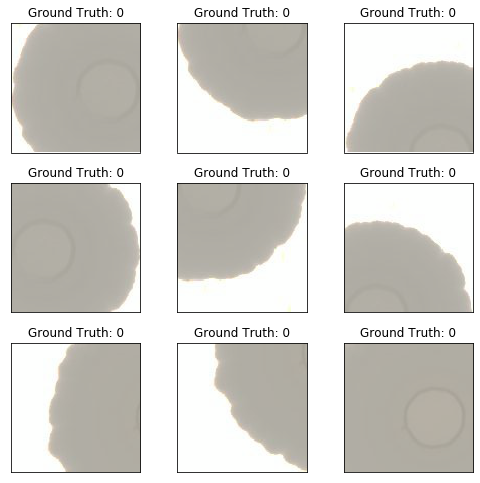

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,7))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(disp_image(example_data[i]), interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


## Building the Network

Now let's go ahead and build our network. We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. As activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers. In PyTorch a nice way to build a network is by creating a new class for the network we wish to build. Let's import a few submodules here for more readable code.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
# https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-he-init.ipynb

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        # 128x128x3 => 128x128x128
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=128, 
                               kernel_size = 3,
                               padding= 2) # p = (1(128-1) - 128 + 3)/2 = 2

        # 64x64x6 => 64x64x12
        self.conv2 = nn.Conv2d(in_channels=128, 
                               out_channels=64, 
                               kernel_size=3,
                               padding= 2) # p = (1(64-1) - 64 + 5)/2 = 2
        self.conv2_drop = nn.Dropout2d()

        # 32x32x12 => 32x32x12
        self.conv3 = nn.Conv2d(in_channels=64, 
                               out_channels=32, 
                               kernel_size=3,
                               padding= 2) # p = (1(64-1) - 64 + 5)/2 = 2
        self.conv3_drop = nn.Dropout2d()

        # 16x16x12 => 16x16x16
        self.conv4 = nn.Conv2d(in_channels=32, 
                               out_channels=16, 
                               kernel_size=5,
                               padding= 2) # p = (1(64-1) - 64 + 5)/2 = 2
        self.conv4_drop = nn.Dropout2d()
        
        self.fc1 = nn.Linear(1024, 64)
        self.fc2 = nn.Linear(64, 10)
        
        # initialising weights with He initialisation
        for m in self.modules():
          if isinstance(m, torch.nn.Conv2d):
              nn.init.kaiming_normal_(m.weight.detach())
              m.bias.detach().zero_()
          elif isinstance(m, torch.nn.Linear):
              nn.init.kaiming_normal_(m.weight.detach())
              m.bias.detach().zero_()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)), 2))
        #print(x.shape)
        x = x.view(-1, 1024)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)


In [0]:
for data, target in loader:
  pass

In [28]:
def weight_scale(x):
  unique, counts = np.unique(x, return_counts=True)
  print(counts.sum()/counts)

target = target.numpy()

# weigh class weights
weight = weight_scale(target)

[19.76763485 11.45192308  3.21891892  6.67226891 17.7761194   2.99434318
 88.22222222]


Broadly speaking we can think of the torch.nn layers as which contain trainable parameters while `torch.nn.functional` are purely functional. The `forward()` pass defines the way we compute our output using the given layers and functions. It would be perfectly fine to print out tensors somewhere in the forward pass for easier debugging. This comes in handy when experimenting with more complex models. Note that the forward pass could make use of e.g. a member variable or even the data itself to determine the execution path - and it can also make use of multiple arguments!

Now let's `initialize` the network and the optimizer.

In [0]:
network = Net()
optimizer = optim.Adam(network.parameters())
criterion = nn.NLLLoss(weight)

**Note**: If we were using a GPU for training, we should have also sent the network parameters to the GPU using e.g. `network.cuda()`. It is important to transfer the network's parameters to the appropriate device before passing them to the optimizer, otherwise the optimizer will not be able to keep track of them in the right way.

## Training the Model

Time to build our training loop. First we want to make sure our network is in training mode. Then we iterate over all training data once per epoch. Loading the individual batches is handled by the DataLoader. First we need to manually set the gradients to zero using `optimizer.zero_grad()` since PyTorch by default accumulates gradients. We then produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label. The `backward()` call we now collect a new set of gradients which we propagate back into each of the network's parameters using `optimizer.step()`. For more detailed information about the inner workings of PyTorch's automatic gradient system, see the official docs for autograd (highly recommended).

We'll also keep track of the progress with some printouts. In order to create a nice training curve later on we also create two lists for saving training and testing losses. On the x-axis we want to display the number of training examples the network has seen during training. 

In [0]:
train_losses = []
train_counter = []
val_losses = []
val_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

We'll run our test loop once before even starting the training to see what accuracy/loss we achieve just with randomly initialized network parameters. Can you guess what our accuracy might look like for this case?

In [0]:
def train(epoch):
  network.train()

  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, 
            batch_idx * len(data), 
            len(train_loader.dataset),
            100. * batch_idx / len(train_loader), 
            loss.item()))
      
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      
      torch.save(network.state_dict(), '/results/model.pth')
      torch.save(optimizer.state_dict(), '/results/optimizer.pth')

Neural network modules as well as optimizers have the ability to save and load their internal state using `.state_dict()`. With this we can continue training from previously saved state dicts if needed - we'd just need to call `.load_state_dict(state_dict)`. 

Now for our test loop. Here we sum up the test loss and keep track of correctly classified digits to compute the accuracy of the network. 

In [0]:
def validate():
  network.eval()
  val_loss = 0
  correct = 0

  with torch.no_grad():
    
    for data, target in val_loader:
      
      output = network(data)
      val_loss += criterion(output, 
                             target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()

  val_loss /= len(val_loader.dataset)
  val_losses.append(val_loss)

  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, 
        correct, 
        len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

In [0]:
! mkdir ../results/ 

Using the context manager `no_grad()` we can avoid storing the computations done producing the output of our network in the computation graph.

Time to run the training! We'll manually add a `test()` call before we loop over n_epochs to evaluate our model with randomly initialized parameters.

In [44]:
validate()

for epoch in range(1, n_epochs + 1):
  train(epoch)
  validate()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0809, Accuracy: 23/867 (3%)

Train Epoch: 1 [0/4764 (0%)]	Loss: 15.592920
Train Epoch: 1 [1280/4764 (27%)]	Loss: 2.165912
Train Epoch: 1 [2560/4764 (53%)]	Loss: 1.802437
Train Epoch: 1 [3840/4764 (80%)]	Loss: 2.043579

Test set: Avg. loss: 0.0331, Accuracy: 386/867 (45%)

Train Epoch: 2 [0/4764 (0%)]	Loss: 1.793077
Train Epoch: 2 [1280/4764 (27%)]	Loss: 1.712844
Train Epoch: 2 [2560/4764 (53%)]	Loss: 1.615583
Train Epoch: 2 [3840/4764 (80%)]	Loss: 1.652127

Test set: Avg. loss: 0.0309, Accuracy: 241/867 (28%)

Train Epoch: 3 [0/4764 (0%)]	Loss: 1.661838
Train Epoch: 3 [1280/4764 (27%)]	Loss: 1.669114
Train Epoch: 3 [2560/4764 (53%)]	Loss: 1.542693
Train Epoch: 3 [3840/4764 (80%)]	Loss: 1.566392

Test set: Avg. loss: 0.0284, Accuracy: 233/867 (27%)

Train Epoch: 4 [0/4764 (0%)]	Loss: 1.579730
Train Epoch: 4 [1280/4764 (27%)]	Loss: 1.705432
Train Epoch: 4 [2560/4764 (53%)]	Loss: 1.411473
Train Epoch: 4 [3840/4764 (80%)]	Loss: 1.543767

Test set: Avg. loss: 0.0287,

## Evaluating the Model's Performance

And that's it. With just 3 epochs of training we  managed to achieve 39% accuracy on the test set! We started out with randomly initialized parameters and as expected only got about 2% accuracy on the test set before starting the training.

Let's plot our training curve.

Text(0, 0.5, 'negative log likelihood loss')

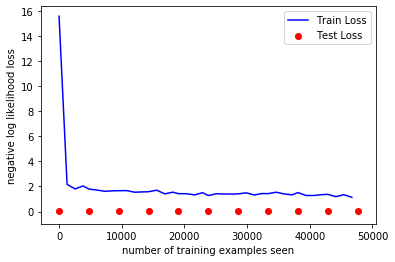

In [46]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(val_counter, val_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Judging from the training curve  it looks like we could even continue training for a few more epochs!


But before that let's again look at a few examples as we did earlier and compare the model's output.

In [0]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
output[0]

tensor([-2.5652, -2.0844, -1.0489, -1.6185, -2.3974, -1.9616, -4.0728, -7.6187,
        -7.5413, -7.4896])

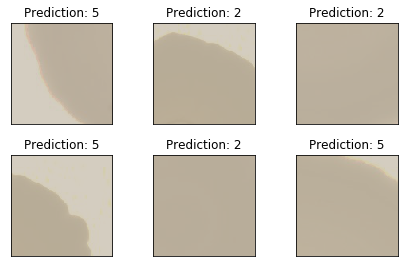

In [0]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(disp_image(example_data[i]), interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])



## Continued Training from Checkpoints

Now let's continue training the network, or rather see how we can continue training from the state_dicts we saved during our first training run. We'll initialize a new set of network and optimizers.

In [0]:
continued_network = Net()
continued_optimizer = optim.Adam(network.parameters())

Using `.load_state_dict()` we can now load the internal state of the network and optimizer when we last saved them.

In [0]:
network_state_dict = torch.load('/results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

Again running a training loop should immediately pick up the training where we left it. To check on that let's simply use the same lists as before to keep track of the loss values. Due to the way we constructed the test counter for the number of training examples seen we manually have to append to it here.

In [0]:
for i in range(10,15):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 10 [0/4764 (0%)]	Loss: 1.393428
Train Epoch: 10 [1280/4764 (27%)]	Loss: 1.260425
Train Epoch: 10 [2560/4764 (53%)]	Loss: 1.101947
Train Epoch: 10 [3840/4764 (80%)]	Loss: 1.209772

Test set: Avg. loss: 0.0011, Accuracy: 562/867 (65%)

Train Epoch: 11 [0/4764 (0%)]	Loss: 1.312651
Train Epoch: 11 [1280/4764 (27%)]	Loss: 1.217531
Train Epoch: 11 [2560/4764 (53%)]	Loss: 1.311427
Train Epoch: 11 [3840/4764 (80%)]	Loss: 1.234426

Test set: Avg. loss: 0.0012, Accuracy: 556/867 (64%)

Train Epoch: 12 [0/4764 (0%)]	Loss: 1.104714
Train Epoch: 12 [1280/4764 (27%)]	Loss: 1.563061
Train Epoch: 12 [2560/4764 (53%)]	Loss: 1.175901
Train Epoch: 12 [3840/4764 (80%)]	Loss: 1.210090

Test set: Avg. loss: 0.0013, Accuracy: 534/867 (62%)

Train Epoch: 13 [0/4764 (0%)]	Loss: 1.372639
Train Epoch: 13 [1280/4764 (27%)]	Loss: 1.088563
Train Epoch: 13 [2560/4764 (53%)]	Loss: 1.085336
Train Epoch: 13 [3840/4764 (80%)]	Loss: 0.875984

Test set: Avg. loss: 0.0013, Accuracy: 549/867 (63%)

Train Epoch:

Great! We again see a (much slower) increase in test set accuracy from epoch to epoch. Let's visualize this to further inspect the training progress.

Text(0, 0.5, 'negative log likelihood loss')

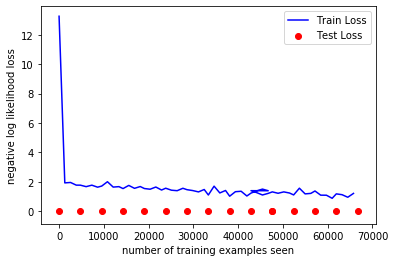

In [0]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

That still looks like a rather smooth learning curve just as if we initially would've trained for 8 epochs! Remember that we just appended values to the same lists starting from the 5th red dot onward.

From this we can conclue two things:

1. Continuing from the checkpointed internal state worked as intended.

2. We still don't seem to run into overfitting issues! It looks like our dropout layers did a good job regularizing the model.

In summary we built a new environment with PyTorch and TorchVision, used it to classifiy handwritten digits from the MNIST dataset and hopefully developed a good intuition using PyTorch. For further information the official PyTorch documentation is really nicely written and the forums are also quite active!

## Confusion Matrix

In [48]:
network.eval()

with torch.no_grad():
  for data, target in val_loader:
    output = network(data)
    pred = output.data.max(1, keepdim=True)[1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
pred = pred.numpy().reshape(-1)

In [50]:
pred.shape

(35,)

In [0]:
target = target.numpy()

In [0]:
from pandas import DataFrame as df
from sklearn.metrics import confusion_matrix

In [0]:
cm = confusion_matrix(target, pred)

In [0]:
vals = [i+1 for i in range(3)]

In [58]:
df2 = df(cm, vals, vals)
df2

,1,2,3
1,0,0,0
2,21,0,0
3,14,0,0


In [0]:
def value_counts(x):
  unique, counts = np.unique(x, return_counts=True)
  print(np.asarray((unique, counts)).T)

In [0]:
value_counts(target)

[[  0  33]
 [  1  54]
 [  2 233]
 [  3 114]
 [  4  31]
 [  5 388]
 [  6  14]]


In [0]:
value_counts(pred)

[[  2 518]
 [  5 349]]


## Visualise Activations

In [0]:
# from torch.utils.tensorboard import SummaryWriter
# import numpy as np

# writer = SummaryWriter()

# writer.add_pr_curve('pr_curve', target, pred, 0)
# writer.close()

In [0]:
# ! zip -r -X runs.zip runs

  adding: runs/ (stored 0%)
  adding: runs/Nov24_07-48-13_6abaa22567ef/ (stored 0%)
  adding: runs/Nov24_07-48-13_6abaa22567ef/events.out.tfevents.1574581693.6abaa22567ef.123.5 (deflated 5%)


In [0]:
# https://pytorch.org/docs/stable/tensorboard.html
# %load_ext tensorboard
# %tensorboard --logdir "$runs"

In [0]:
# http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html
# https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/gradcam.py



In [0]:
# https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html